In [ ]:
!pip install pymongo

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import pickle
pd.options.mode.chained_assignment = None
import numpy as np
import os
import json

Проверим нашу модель на всех студентах, которые пользуются гитлабом для ведения проекта

In [3]:
connection = {'host': '***',
              'username': '***',
              'password': '***'}


In [4]:
#класс для подключения к базе данных
from pymongo import MongoClient

class FootprintClient:
    
    def __init__(self, connection: dict):
        
        self.host = connection['host']
        self.username = connection['username']
        self.password = connection['password']
    
    def gitlab_connect(self, db):

        client = MongoClient(self.host,
                          username=self.username,
                          password=self.password)
        conn = client[db]
        return conn


In [16]:
#класс для создания датасета с признаками по гитлабу
class GitlabPrepocessor(FootprintClient):
    
    def __init__(self, connection):
        super().__init__(connection)
        self.gitlab = self._query_gitlab_projects()
    def _query_gitlab_projects(self, filtr={}, query={}):
        db = self.gitlab_connect('test')
        collection = db.gitlab_commits
        return list(collection.find(filtr, query))
    
    def get_feature_dataset(self):
        df = pd.DataFrame(self.gitlab)
        df = pd.concat([df[['created_at', 'user_id', 'project']], pd.json_normalize(df['stats'])], axis=1)
        df['created_at'] = df['created_at'].apply(lambda x: str(x.year) + str(x.day))
        agg_func_math = {
          'additions': 'sum',
          'deletions': 'sum',
          'created_at': 'nunique'
        }
        df_features = df.groupby(['user_id', 'project']).agg(agg_func_math).reset_index()
        df_features = df_features[['user_id', 'project', 'created_at', 'additions', 'deletions']].rename(columns={"user_id": "username", 
                                                                                                    "project": "namespaceName",
                                                                                                    "created_at":"activeMonthCount", 
                                                                                                    "additions":"additionsSum", 
                                                                                                    "deletions":"deletionsSum"})
        return df_features


In [17]:
#класс для подсчета проектного рейтинга
class ProjectRateCalculator:
    
    def __init__(self, df, model_path, scaler_path):
        self.username = df['username']
        self.scaler = self._load_scaler(scaler_path)
        self.df = self.scaler.transform(df.drop(['username', 'namespaceName'], axis=1))
        self.model = self._load_model(model_path)
    def _load_model(self, model_path):
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        return model
        
    def _load_scaler(self, scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        return scaler

    def calculate_project_rate(self, save=True):

        df_project_rate = pd.DataFrame(np.clip(self.model.predict(self.df), 0, 10), columns=['rating'])
        df_project_rate.dropna(inplace=True)
        df_project_rate.reset_index(drop=True, inplace=True)
        df_project_rate = pd.concat([self.username, df_project_rate], axis=1).groupby('username', as_index=False).mean()
        df_project_rate['percentile_rating'] = ((df_project_rate['rating'].rank(method='max', pct=True)*100)-100).abs()
        df_project_rate['percentile_rank'] = (df_project_rate['rating'].rank(method='max')-len(df_project_rate)).abs()+1

        return df_project_rate




In [18]:
gp = GitlabPrepocessor(connection)

In [19]:
df = gp.get_feature_dataset()

In [20]:
viwe_df = df[['namespaceName',	'activeMonthCount',	'additionsSum',	'deletionsSum']]
viwe_df.head()

,namespaceName,activeMonthCount,additionsSum,deletionsSum
0,641f58b03aae02671b446d36,1,262,20
1,641f58b03aae02671b446d38,3,366,140
2,641f58b43aae02671b446d51,1,144,11
3,641f58b53aae02671b446d53,1,130,0
4,641f58b53aae02671b446d55,2,5122,21


In [21]:
model_path = '/content/drive/MyDrive/model/model.pkl'
scaler_path = '/content/drive/MyDrive/model/scaler.pkl'

pr = ProjectRateCalculator(df, model_path, scaler_path)

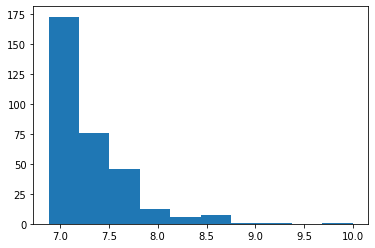

In [22]:
plt.hist(pr.calculate_project_rate()['rating']);

На графике выше изображена гистограмма распределения проектного рейтинга для всех студентов. Мы получили менее дискретные предсказания по сравнению с рейтингом, предсказанным с помощью CatBoost. 

In [23]:
pr.calculate_project_rate().sort_values(by='rating')

,username,rating,percentile_rating,percentile_rank
99,63c56d245dcb5bfd4e6391a4,6.880847,99.690402,323.0
321,63c56dffb7db13391243442a,6.880848,99.380805,322.0
141,63c56d3c5dcb5bfd4e6393dc,6.880850,99.071207,321.0
195,63c56d595dcb5bfd4e639665,6.880851,98.761610,320.0
105,63c56d2a5dcb5bfd4e639229,6.880853,98.452012,319.0
...,...,...,...,...
183,63c56d505dcb5bfd4e6395b8,8.676723,1.238390,5.0
246,63c56d775dcb5bfd4e639937,8.686134,0.928793,4.0
11,63c56cf45dcb5bfd4e638d46,8.890177,0.619195,3.0
36,63c56cfd5dcb5bfd4e638e1c,9.256699,0.309598,2.0


Также проверим наше изнчальное положение: рейтинг коррелирует с каждым из признаков. Хотя, строя модель линейной регрессии, мы уже подразумеваем наличии корреляции, однако для чистоты эксперимента проверим это сами  \


Для этого выдвеним две гипотезы:

 - H0 - различие между выборочным коэффициентом корреляции r и ρ = 0 незначимо 
 - H1 - различие между r и p=0 значимо, и следовательно, между переменными имеется существенная связь. 

In [24]:
from scipy.stats import spearmanr

In [25]:
merge_df = pd.merge(left=df, right=pr.calculate_project_rate(), on='username')
merge_df.sort_values(by='rating', ascending=False).sample(10)[merge_df.columns[1:]]

,namespaceName,activeMonthCount,additionsSum,deletionsSum,rating,percentile_rating,percentile_rank
1402,641f5af13aae02671b4493c3,2,108,0,6.920493,66.563467,216.0
956,641f5b013aae02671b4494c0,1,38,0,6.895921,69.040248,224.0
1158,641f58f83aae02671b447137,1,1576,0,6.882797,73.993808,240.0
236,641f5ab33aae02671b448fff,3,921601,19,7.314322,33.436533,109.0
958,641f5b013aae02671b4494c7,1,38,0,6.895921,69.040248,224.0
164,641f5a0f3aae02671b448452,1,694,54,7.314322,33.436533,109.0
154,641f59fe3aae02671b4482e2,4,463,284,7.314322,33.436533,109.0
1070,641f5b6e3aae02671b449b54,3,272,224,7.240763,41.795666,136.0
946,641f5ae33aae02671b4492ba,1,1,0,6.895921,69.040248,224.0
1489,641f5ad03aae02671b449194,1,14000,0,6.898166,68.111455,221.0


In [27]:
print('deletionsSum: ')
print("Corr: " + str(spearmanr(merge_df['deletionsSum'], merge_df['rating'])[0]))
print("Pvalue: " + str(spearmanr(merge_df['deletionsSum'], merge_df['rating'])[1]))

deletionsSum: 
Corr: 0.5861142642902248
Pvalue: 3.8428730118944735e-147


In [28]:
print('additionsSum: ')
print("Corr: " + str(spearmanr(merge_df['additionsSum'], merge_df['rating'])[0]))
print("Pvalue: " + str(spearmanr(merge_df['additionsSum'], merge_df['rating'])[1]))

additionsSum: 
Corr: 0.4840632115627607
Pvalue: 4.6419762669245636e-94


In [29]:
print('activeMonthCount: ')
print("Corr: " + str(spearmanr(merge_df['activeMonthCount'], merge_df['rating'])[0]))
print("Pvalue: " + str(spearmanr(merge_df['activeMonthCount'], merge_df['rating'])[1]))

activeMonthCount: 
Corr: 0.6324839633613867
Pvalue: 3.5773316926904895e-178


Можем заметить, что, действительно, для каждого признака значение p_value ~ 0. Следовательно мы отклоняем нулевую гипотезу

Сопоставим значению рейтинга значения признаков и посмотрим на адекватность результатов


In [31]:
merge_df.sort_values(by='rating', ascending=True)[merge_df.columns[1:]].head(10)

,namespaceName,activeMonthCount,additionsSum,deletionsSum,rating,percentile_rating,percentile_rank
1083,641f5c4c3aae02671b44a9bf,1,0,0,6.880847,99.690402,323.0
1586,641f5b943aae02671b449de0,1,1,0,6.880848,99.380805,322.0
1146,641f5b1d3aae02671b449628,1,2,0,6.880850,99.071207,321.0
1272,641f5b1d3aae02671b449628,1,3,0,6.880851,98.761610,320.0
1092,641f5b363aae02671b4497c7,1,2,1,6.880853,98.452012,319.0
1088,641f5c323aae02671b44a7fa,1,0,2,6.880854,98.142415,318.0
1362,641f5b023aae02671b4494cd,1,2,0,6.880854,97.832817,317.0
1363,641f5b403aae02671b449862,1,9,0,6.880854,97.832817,317.0
1559,641f5ca03aae02671b44af1e,1,1,1,6.880855,97.523220,316.0
1558,641f5c713aae02671b44abe3,1,3,2,6.880855,97.523220,316.0


In [33]:
merge_df.sort_values(by='rating', ascending=True)[merge_df.columns[1:]].tail(10)

,namespaceName,activeMonthCount,additionsSum,deletionsSum,rating,percentile_rating,percentile_rank
1353,641f5b8f3aae02671b449d86,6,506,176,8.503851,2.476780,9.0
1549,641f5b843aae02671b449c90,10,3625,1841,8.506145,2.167183,8.0
524,641f5a493aae02671b4488cb,3,1004418,9667,8.513648,1.857585,7.0
1253,641f58ed3aae02671b44706d,10,14324,2486,8.521477,1.547988,6.0
1252,641f5c713aae02671b44abe3,7,150,134,8.676723,1.238390,5.0
1251,641f5c033aae02671b44a502,15,642,560,8.676723,1.238390,5.0
1435,641f5b513aae02671b449972,11,4752,1585,8.686134,0.928793,4.0
500,641f5bb33aae02671b449fe0,12,14569,5424,8.890177,0.619195,3.0
567,641f5a493aae02671b4488cb,4,266465,464129,9.256699,0.309598,2.0
1115,641f5b9b3aae02671b449e46,21,77946,100222,10.000000,0.000000,1.0


Посмотрим на веса модели

In [35]:
pr.model.coef_

array([1.25598085, 1.06985655, 0.72770863])

Веса одного порядка, следовательно модель устойчива. Также мы можем проинтерпретировать полученный результат: все три признака вносят существенный вклад в итоговый рейтинг. Важность признака слегка падает слева направо (activeMonthCoun -> additionsSum	-> deletionsSum)